## Contents
* read data
* drop redeundant columns
* one-hot encoding
* sliding window method
* identify response variable and predictors
* dimensionality reduction
* split into training and testing datasets
* data normalisation of training datasets
* define the model
* choose hyperparameters to tune
* identify the best hyperparameters using gridsearch
* make predictions based on these hyperparameters
* assess model performance 
* perform SHAP analysis

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt
import shap
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
base_dir = os.path.dirname(os.path.abspath("..\data"))
path = os.path.join(base_dir, r"data").replace("\\code","")
os.chdir(path) 

In [3]:
data = pd.read_csv("Cleaned data\data.csv")

In [4]:
# filter date
df = data[data['DATE'] > '2018-08-01']

# drop columns
df = df.drop(columns=[
    "DATE","MONTHDATE","MIN","ACCMIN","MAX","ACCMAX","RAINPERIOD","QUANTITY","QUANTITYMONTHCUM","QUANTITYTOTALCUM","HUMIDITYMIN","HUMIDITYMAX", "RAIN", "WEEKEND"
], errors="ignore").reset_index(drop=True)
df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,TEMPAVE,RRP,FORECASTDEMAND,OUTPUT,WEEKDAY
0,2018,8,2,0.433778,16.377778,8655.004063,0.0,12.1,12.55,72.961957,8302.718612,165.17,3
1,2018,8,3,0.620851,14.829787,8353.189132,0.0,13.3,13.75,78.868542,8129.498010,165.17,4
2,2018,8,4,0.608511,20.659574,7742.749514,0.0,13.3,13.65,66.300000,7133.447593,165.17,5
3,2018,8,5,0.433333,18.488889,7645.043264,0.0,13.4,11.65,62.830213,NaN,165.17,6
4,2018,8,6,0.545000,15.978261,8609.566215,1.0,6.3,11.45,82.375333,9403.610320,165.17,0


In [5]:
#one hot encoding weekday
def one_hot_encode(df, col, names):
    array = np.array(df[col])
    integer_encoded = array.reshape(len(array), 1)
    onehotencoder = OneHotEncoder()
    onehot_encoded = onehotencoder.fit_transform(integer_encoded).toarray()
    df_encoded = pd.DataFrame(onehot_encoded, columns=names)
    df = pd.concat([df, df_encoded], axis=1)
    df = df.drop(columns=[col], errors="ignore")
    return df

df = one_hot_encode(df, col="WEEKDAY", names=['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'])
df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,TEMPAVE,RRP,FORECASTDEMAND,OUTPUT,MON,TUE,WED,THU,FRI,SAT,SUN
0,2018,8,2,0.433778,16.377778,8655.004063,0.0,12.1,12.55,72.961957,8302.718612,165.17,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2018,8,3,0.620851,14.829787,8353.189132,0.0,13.3,13.75,78.868542,8129.498010,165.17,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2018,8,4,0.608511,20.659574,7742.749514,0.0,13.3,13.65,66.300000,7133.447593,165.17,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2018,8,5,0.433333,18.488889,7645.043264,0.0,13.4,11.65,62.830213,NaN,165.17,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2018,8,6,0.545000,15.978261,8609.566215,1.0,6.3,11.45,82.375333,9403.610320,165.17,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
def create_lags(df, lookback, columns):
    for col in columns:
        if col == "TOTALDEMAND":
            df["y"] = df[col].shift(-1) #response variable, total demand 1 day look ahead
        for i in range(lookback + 1):
            if i == 0: pass
            else: df[col+f" (t-{i})"] = df[col].shift(i) #i day/s look back 
    return df 

In [7]:
# apply sliding window
lookback = 3 #day/s
columns = ["HUMIDITY","WINDSPEED","TOTALDEMAND","HOLIDAY","SOLAR","RRP","OUTPUT","TEMPAVE"]
df_lagged = df.copy()
df_lagged = create_lags(df_lagged, lookback, columns)
df_lagged = df_lagged.dropna()
print(len(df_lagged.columns))
df_lagged.head()

44


,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,TEMPAVE,RRP,FORECASTDEMAND,OUTPUT,MON,TUE,WED,THU,FRI,SAT,SUN,HUMIDITY (t-1),HUMIDITY (t-2),HUMIDITY (t-3),WINDSPEED (t-1),WINDSPEED (t-2),WINDSPEED (t-3),y,TOTALDEMAND (t-1),TOTALDEMAND (t-2),TOTALDEMAND (t-3),HOLIDAY (t-1),HOLIDAY (t-2),HOLIDAY (t-3),SOLAR (t-1),SOLAR (t-2),SOLAR (t-3),RRP (t-1),RRP (t-2),RRP (t-3),OUTPUT (t-1),OUTPUT (t-2),OUTPUT (t-3),TEMPAVE (t-1),TEMPAVE (t-2),TEMPAVE (t-3)
4,2018,8,6,0.545000,15.978261,8609.566215,1.0,6.3,11.45,82.375333,9403.610320,165.17,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.433333,0.608511,0.620851,18.488889,20.659574,14.829787,8634.633681,7645.043264,7742.749514,8353.189132,0.0,0.0,0.0,13.4,13.3,13.3,62.830213,66.300000,78.868542,165.17,165.17,165.17,11.65,13.65,13.75
5,2018,8,7,0.506957,21.956522,8634.633681,0.0,13.8,13.70,79.490638,8894.224783,165.17,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.545000,0.433333,0.608511,15.978261,18.488889,20.659574,8682.496528,8609.566215,7645.043264,7742.749514,1.0,0.0,0.0,6.3,13.4,13.3,82.375333,62.830213,66.300000,165.17,165.17,165.17,11.45,11.65,13.65
6,2018,8,8,0.363778,26.866667,8682.496528,0.0,12.4,10.80,81.097250,8670.595620,165.17,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.506957,0.545000,0.433333,21.956522,15.978261,18.488889,8618.231354,8634.633681,8609.566215,7645.043264,0.0,1.0,0.0,13.8,6.3,13.4,79.490638,82.375333,62.830213,165.17,165.17,165.17,13.70,11.45,11.65
7,2018,8,9,0.408667,17.933333,8618.231354,0.0,14.1,11.50,92.149778,8551.659859,165.17,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.363778,0.506957,0.545000,26.866667,21.956522,15.978261,8420.668507,8682.496528,8634.633681,8609.566215,0.0,0.0,1.0,12.4,13.8,6.3,81.097250,79.490638,82.375333,165.17,165.17,165.17,10.80,13.70,11.45
8,2018,8,10,0.592273,12.613636,8420.668507,0.0,14.1,13.25,80.855111,8308.943141,165.17,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.408667,0.363778,0.506957,17.933333,26.866667,21.956522,7523.944861,8618.231354,8682.496528,8634.633681,0.0,0.0,0.0,14.1,12.4,13.8,92.149778,81.097250,79.490638,165.17,165.17,165.17,11.50,10.80,13.70


In [8]:
# define X matrix and response variable
y = df_lagged[["y"]]
X = df_lagged.drop(columns=["y"], axis=1, errors="ignore")
X_all = X.copy() #save for accuracy plotting
X = X.drop(["FORECASTDEMAND"],axis=1)

In [9]:
# train test split - use last year to train (data ends in 08/2022 so set timeframe as 08/2021 to 08/2022)
test_timeframe = df.loc[np.where(((df['YEAR'] == 2021) & (df['MONTH'] > 7)) | (df['YEAR'] == 2022))]
test_len = len(test_timeframe) 
X_train, X_test = X.head(len(X)-test_len), X.tail(test_len)
y_train, y_test = y.head(len(X)-test_len), y.tail(test_len)

In [10]:
SHAP_cols = X_train.columns 
SHAP_cols

Index(['YEAR', 'MONTH', 'DAY', 'HUMIDITY', 'WINDSPEED', 'TOTALDEMAND',
       'HOLIDAY', 'SOLAR', 'TEMPAVE', 'RRP', 'OUTPUT', 'MON', 'TUE', 'WED',
       'THU', 'FRI', 'SAT', 'SUN', 'HUMIDITY (t-1)', 'HUMIDITY (t-2)',
       'HUMIDITY (t-3)', 'WINDSPEED (t-1)', 'WINDSPEED (t-2)',
       'WINDSPEED (t-3)', 'TOTALDEMAND (t-1)', 'TOTALDEMAND (t-2)',
       'TOTALDEMAND (t-3)', 'HOLIDAY (t-1)', 'HOLIDAY (t-2)', 'HOLIDAY (t-3)',
       'SOLAR (t-1)', 'SOLAR (t-2)', 'SOLAR (t-3)', 'RRP (t-1)', 'RRP (t-2)',
       'RRP (t-3)', 'OUTPUT (t-1)', 'OUTPUT (t-2)', 'OUTPUT (t-3)',
       'TEMPAVE (t-1)', 'TEMPAVE (t-2)', 'TEMPAVE (t-3)'],
      dtype='object')

In [11]:
# define scaler and transform data
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test))

In [12]:
# Define the XGBoost model 
model = xgb.XGBRegressor() 

In [46]:
# hyperparameters (allowed ranges noted) 
params = {
    'colsample_bytree': [0.8, 1], #(0,1]
    'gamma': [0, 0.01], #[0,1]
    'learning_rate': [0.04, 0.05], #[0,1]
    'max_depth': [2, 3, 4], #[0,inf]
    'n_estimators': [290, 300, 310], #[0,inf]
    'reg_alpha': [2, 3, 4], #[0,inf]
    'reg_lambda': [1, 2, 3], #[1,inf]
    'subsample': [0.6, 0.7, 0.8], #(0,1]
} 

In [47]:
# identify best hyperparameters using gridsearch 
grid = GridSearchCV(model, params, cv=5, n_jobs=-1) 
grid.fit(X_train_scaled, y_train) 

In [ ]:
# best hyperparameters and score 
print("Best Hyperparameters: ", grid.best_params_) 
print("Best Score: ", grid.best_score_) 

Best Hyperparameters:  {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 2, 'reg_lambda': 2, 'subsample': 0.7}
Best Score:  0.7953536002839227


In [16]:
# # print all results 
# print("------ All Results ------- ")
# means = grid.cv_results_['mean_test_score']
# stds = grid.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, grid.cv_results_['params']):
#     print("   %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
# print("------ End All Results ------- ") 

In [17]:
# train model using best hyperparameters
best_model = grid.best_estimator_
best_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.01, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [18]:
# predictions on test data 
y_pred = best_model.predict(X_test_scaled)

In [19]:
# print model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error: {:.2f}".format(mae))
print("Root Mean Squared Error: {:.2f}".format(rmse))
print("R Squared Score: {:.2f}".format(r2))

Mean Absolute Error: 318.70
Root Mean Squared Error: 392.85
R Squared Score: 0.70


#### Plot Accuracy

In [20]:
df_lim = X_all.tail(test_len)
df_lim["YTEST"] = y_test
df_lim["YPRED"] = y_pred
df_lim["DATE"] = pd.to_datetime(dict(year=df.YEAR, month=df.MONTH, day=df.DAY))
df_lim["FORECAST"] = df_lim["FORECASTDEMAND"].shift(-1)
df_lim = df_lim[["DATE","TOTALDEMAND","YTEST","YPRED","FORECAST"]]
df_lim = df_lim.iloc[1:,:]

In [21]:
Date = [d.date() for d in df_lim.DATE]
Forecast = df_lim.FORECAST
Pred = df_lim.YPRED
Test = df_lim.YTEST

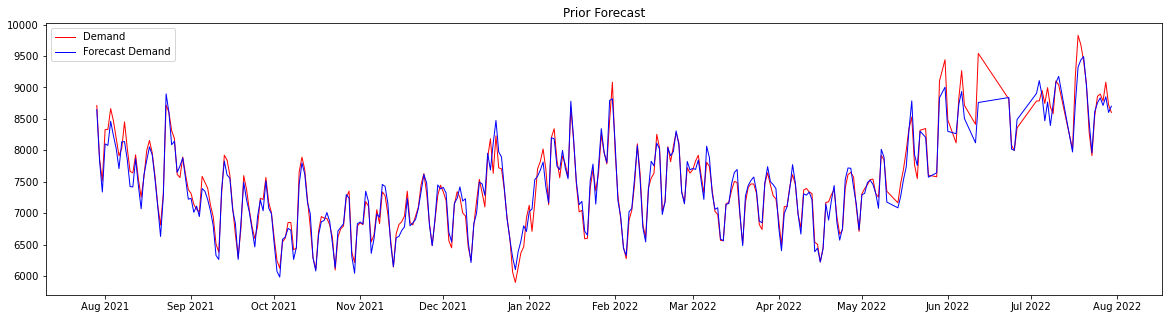

In [22]:
fig, ax = plt.subplots(figsize=(20,5))
forecast = ax.plot(Date, Forecast, linewidth=1, color='red')
test = ax.plot(Date, Test, linewidth=1, color='blue')
ax.legend([test, forecast], labels=["Demand", "Forecast Demand"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title("Prior Forecast")
plt.show()

In [23]:
# print prior model performance
mae1 = mean_absolute_error(Test, Forecast)
mse1 = mean_squared_error(Test, Forecast)
rmse1 = np.sqrt(mse1)
r21 = r2_score(Test, Forecast)

print("Mean Absolute Error: {:.2f}".format(mae1))
print("Root Mean Squared Error: {:.2f}".format(rmse1))
print("R Squared Score: {:.2f}".format(r21)) 

Mean Absolute Error: 112.81
Root Mean Squared Error: 149.14
R Squared Score: 0.96


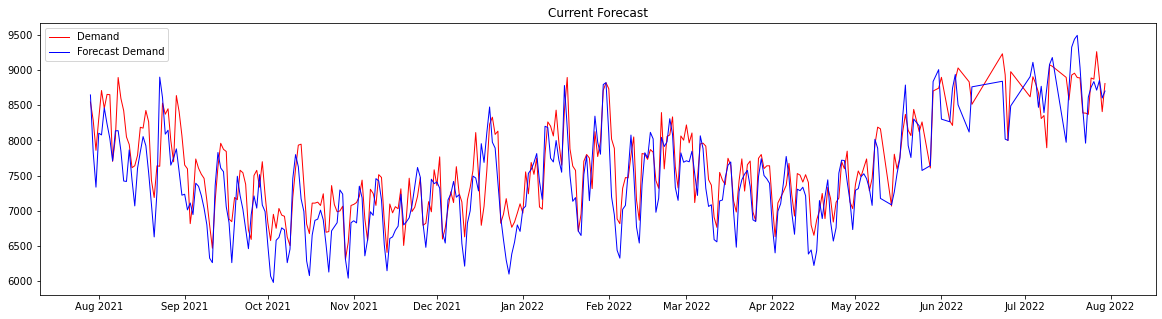

In [24]:
fig, ax = plt.subplots(figsize=(20,5)) 
forecast = ax.plot(Date, Pred, linewidth=1, color='red')
test = ax.plot(Date, Test, linewidth=1, color='blue')
ax.legend([test, forecast], labels=["Demand", "Forecast Demand"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title("Current Forecast")
plt.show()

In [25]:
# print current model performance
mae2 = mean_absolute_error(Test, Pred)
mse2 = mean_squared_error(Test, Pred)
rmse2 = np.sqrt(mse2)
r22 = r2_score(Test, Pred)

print("Mean Absolute Error: {:.2f}".format(mae2))
print("Root Mean Squared Error: {:.2f}".format(rmse2))
print("R Squared Score: {:.2f}".format(r22)) 

Mean Absolute Error: 316.64
Root Mean Squared Error: 389.85
R Squared Score: 0.71


### SHAP

In [26]:
# renaming df columns to include name of feature (important for graphical representations)
X_train_scaled2 = X_train_scaled.copy()
X_train_scaled2.columns = SHAP_cols
X_train_scaled2.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,TEMPAVE,RRP,OUTPUT,MON,TUE,WED,THU,FRI,SAT,SUN,HUMIDITY (t-1),HUMIDITY (t-2),HUMIDITY (t-3),WINDSPEED (t-1),WINDSPEED (t-2),WINDSPEED (t-3),TOTALDEMAND (t-1),TOTALDEMAND (t-2),TOTALDEMAND (t-3),HOLIDAY (t-1),HOLIDAY (t-2),HOLIDAY (t-3),SOLAR (t-1),SOLAR (t-2),SOLAR (t-3),RRP (t-1),RRP (t-2),RRP (t-3),OUTPUT (t-1),OUTPUT (t-2),OUTPUT (t-3),TEMPAVE (t-1),TEMPAVE (t-2),TEMPAVE (t-3)
0,0.0,0.636364,0.166667,0.411617,0.197925,0.662743,0.5,0.169872,0.196147,0.551671,0.332373,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.255701,0.500294,0.517525,0.269134,0.330701,0.165351,0.414401,0.439558,0.596732,0.0,0.0,0.0,0.397436,0.394231,0.394231,0.377759,0.408633,0.520468,0.332373,0.332373,0.332373,0.203152,0.273205,0.276708
1,0.0,0.636364,0.200000,0.358498,0.367486,0.669198,0.0,0.410256,0.274956,0.526003,0.332373,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.411617,0.255701,0.500294,0.197925,0.269134,0.330701,0.662743,0.414401,0.439558,0.5,0.0,0.0,0.169872,0.397436,0.394231,0.551671,0.377759,0.408633,0.332373,0.332373,0.332373,0.196147,0.203152,0.273205
2,0.0,0.636364,0.233333,0.158584,0.506753,0.681521,0.0,0.365385,0.173380,0.540299,0.332373,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.358498,0.411617,0.255701,0.367486,0.197925,0.269134,0.669198,0.662743,0.414401,0.0,0.5,0.0,0.410256,0.169872,0.397436,0.526003,0.551671,0.377759,0.332373,0.332373,0.332373,0.274956,0.196147,0.203152
3,0.0,0.636364,0.266667,0.221260,0.253377,0.664974,0.0,0.419872,0.197898,0.638644,0.332373,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.158584,0.358498,0.411617,0.506753,0.367486,0.197925,0.681521,0.669198,0.662743,0.0,0.0,0.5,0.365385,0.410256,0.169872,0.540299,0.526003,0.551671,0.332373,0.332373,0.332373,0.173380,0.274956,0.196147
4,0.0,0.636364,0.300000,0.477622,0.102494,0.614107,0.0,0.419872,0.259194,0.538144,0.332373,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.221260,0.158584,0.358498,0.253377,0.506753,0.367486,0.664974,0.681521,0.669198,0.0,0.0,0.0,0.419872,0.365385,0.410256,0.638644,0.540299,0.526003,0.332373,0.332373,0.332373,0.197898,0.173380,0.274956


In [27]:
# explain the model's predictions using SHAP values 
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_scaled2)

In [28]:
# visualise the first prediction's explanation
shap.initjs() 
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_scaled2.iloc[0,:])

In [29]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train_scaled2)

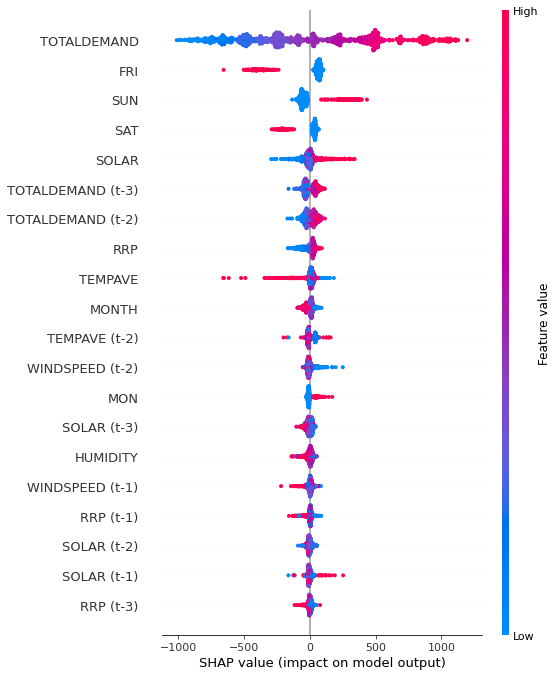

In [30]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train_scaled2)

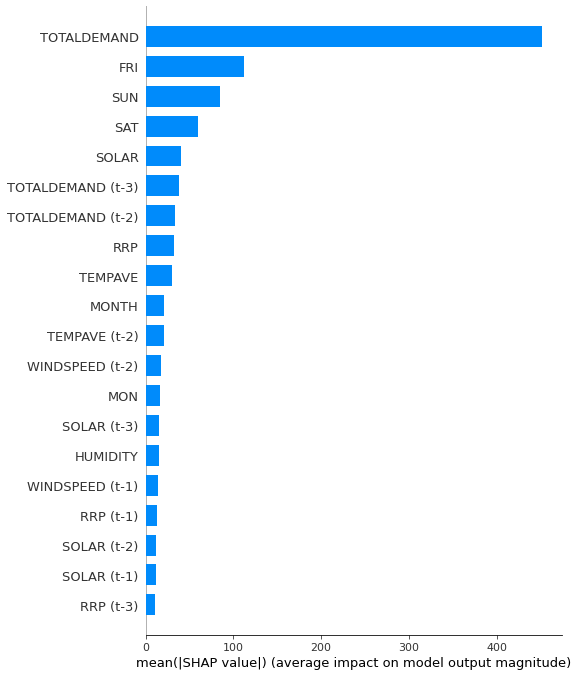

In [31]:
shap.summary_plot(shap_values, X_train_scaled2, plot_type="bar")